# Time Series Forecasting
## Using Machine Learning to Predict Next 3 months Power Generation



In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

Read CSV file

In [183]:
df = pd.read_csv('wind_power_data_merged.csv')


**Convert:**

**df.set_index('Datetime')**: This sets the index of the DataFrame df to the values in the 'DateTime' column. After this operation, the 'DateTime' column will become the index of the DataFrame.

**pd.to_datetime(df.index)**: This converts the index of the DataFrame to datetime objects. It ensures that the index values are interpreted as datetime objects, which allows for easier manipulation and analysis of time-series data.

In [184]:
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

In [185]:
df.index

DatetimeIndex(['2019-01-01 01:00:00', '2019-01-01 02:00:00',
               '2019-01-01 03:00:00', '2019-01-01 04:00:00',
               '2019-01-01 05:00:00', '2019-01-01 06:00:00',
               '2019-01-01 07:00:00', '2019-01-01 08:00:00',
               '2019-01-01 09:00:00', '2019-01-01 10:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=43823, freq=None)

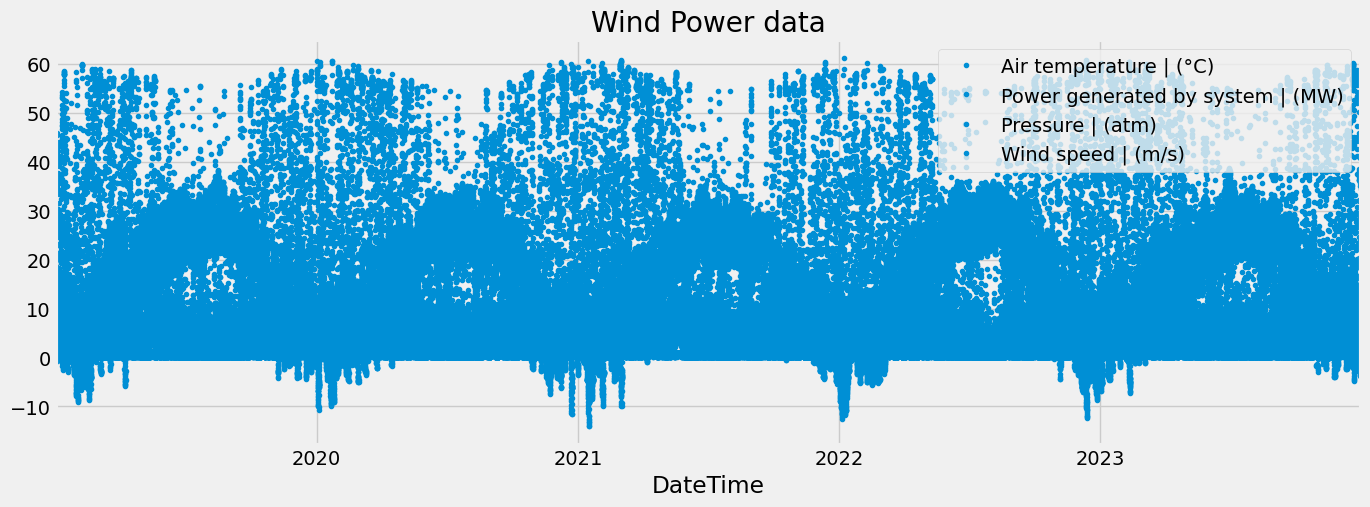

In [186]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Wind Power data')
plt.show()

# Train / Test Split

TRAINING AND TESTING:   <01.01.2022   3:2  >=01.01.2022

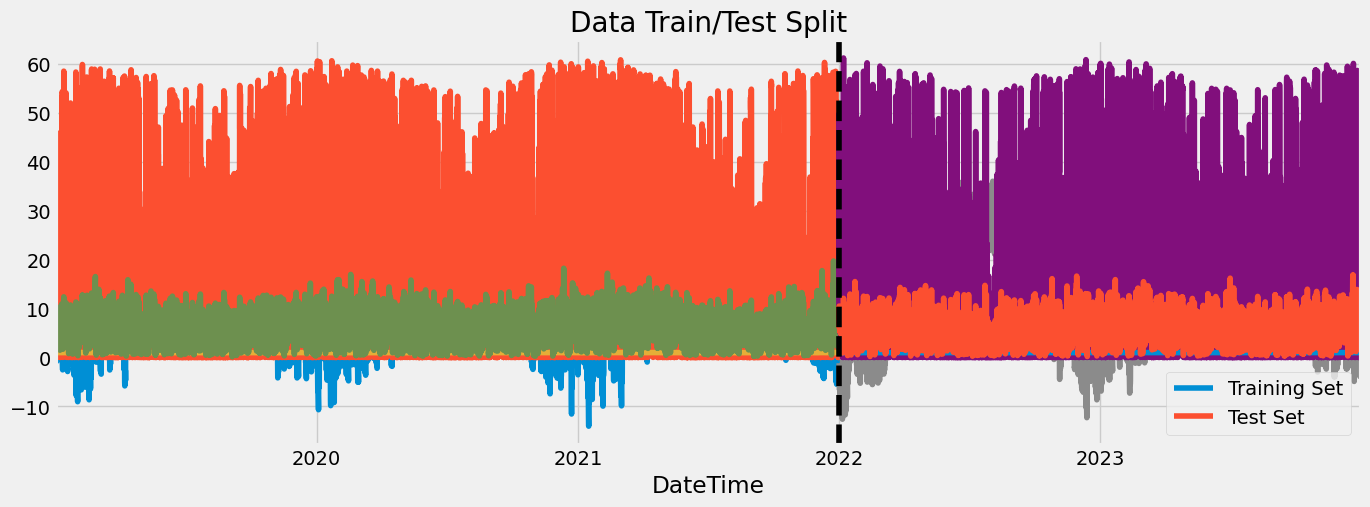

In [187]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**Jan 1st week 2023**

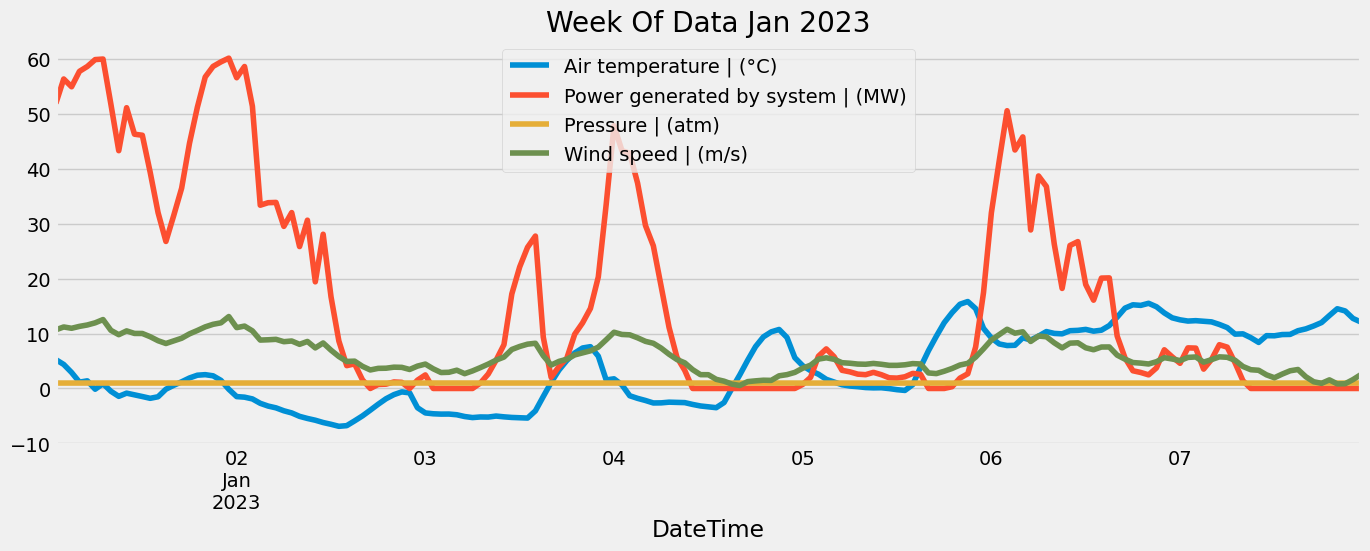

In [188]:
df.loc[(df.index > '01-01-2023') & (df.index < '01-08-2023')] \
    .plot(figsize=(15, 5), title='Week Of Data Jan 2023')
plt.show()

# Feature Creation

In [189]:
df.index

DatetimeIndex(['2019-01-01 01:00:00', '2019-01-01 02:00:00',
               '2019-01-01 03:00:00', '2019-01-01 04:00:00',
               '2019-01-01 05:00:00', '2019-01-01 06:00:00',
               '2019-01-01 07:00:00', '2019-01-01 08:00:00',
               '2019-01-01 09:00:00', '2019-01-01 10:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=43823, freq=None)

In [190]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

<ipython-input-191-893e2f5107c9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='Power generated by system | (MW)',palette='RdBu')


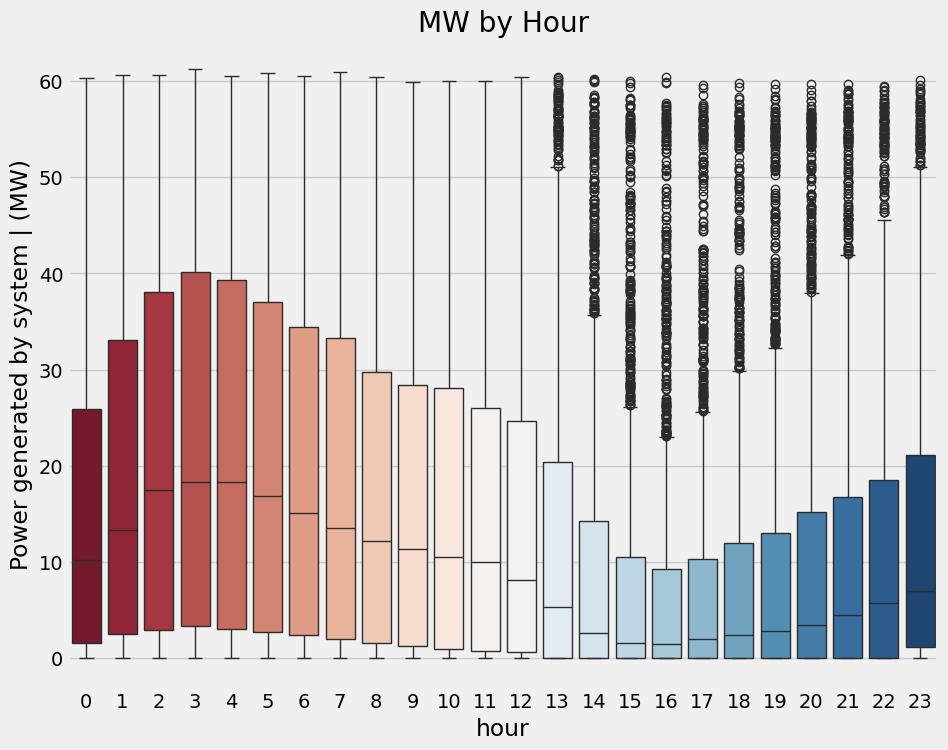

In [191]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Power generated by system | (MW)',palette='RdBu')
ax.set_title('MW by Hour')
plt.show()

<ipython-input-193-60cae7caa544>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='Power generated by system | (MW)', palette='Blues')


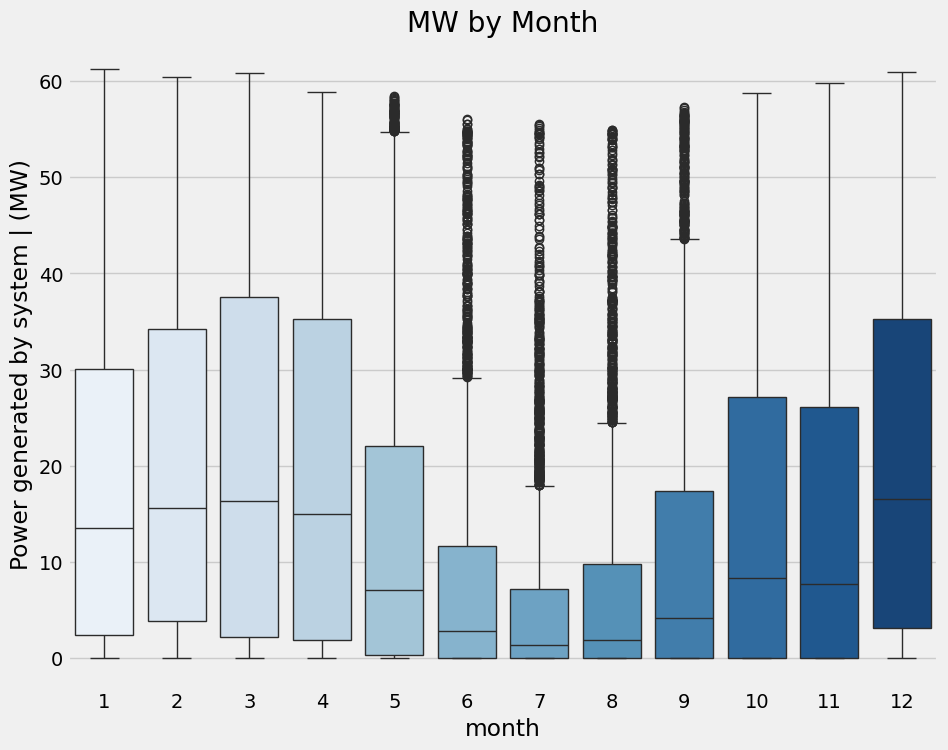

In [193]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Power generated by system | (MW)', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [194]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Power generated by system | (MW)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [195]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:21.69692	validation_1-rmse:20.64694


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:59:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[77]	validation_0-rmse:14.90362	validation_1-rmse:15.89144


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

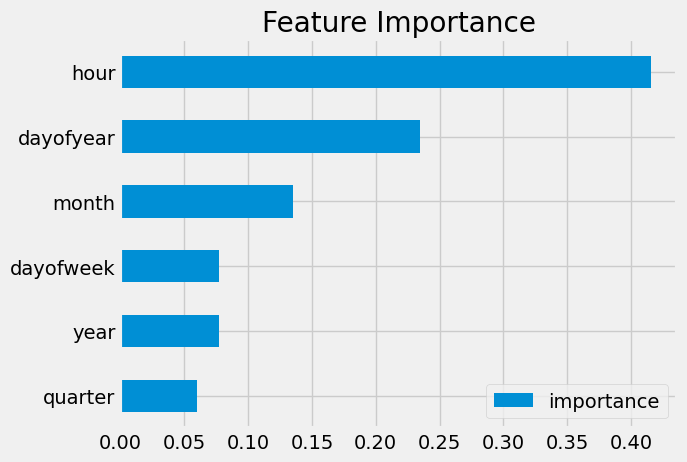

In [196]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

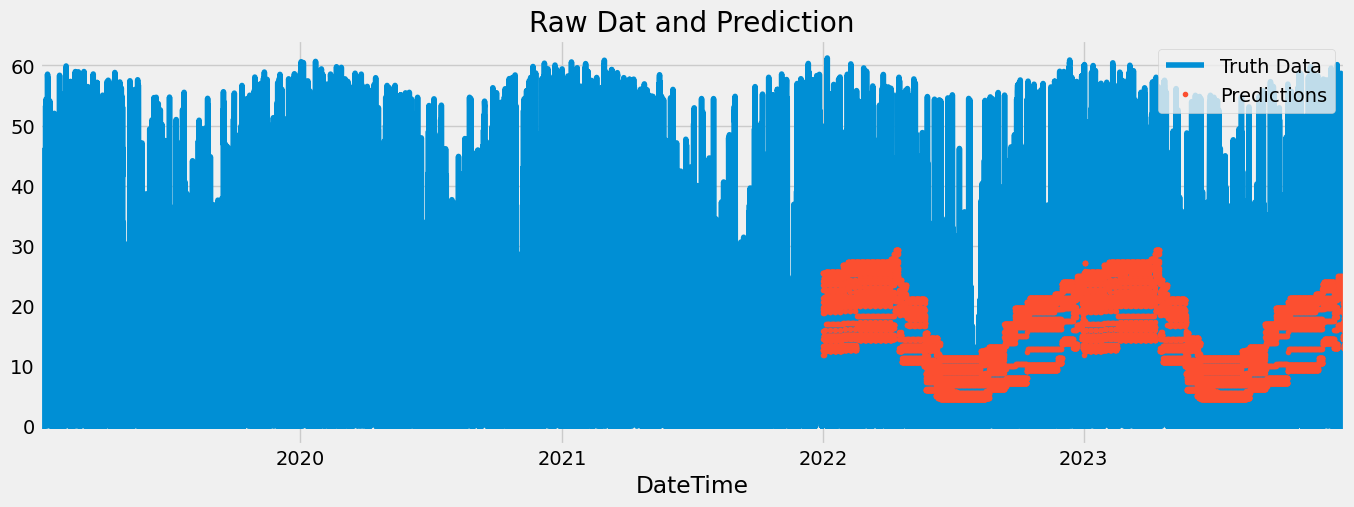

In [197]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True, suffixes=('_df', '_test'))
ax = df[['Power generated by system | (MW)']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


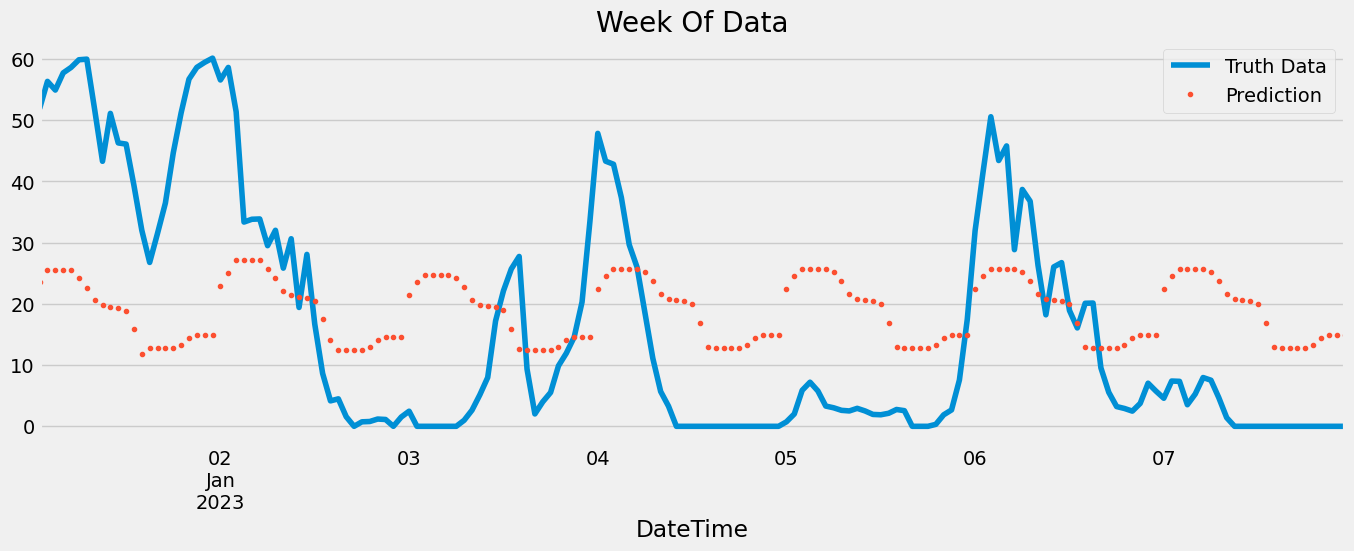

In [198]:
ax = df.loc[(df.index > '01-01-2023') & (df.index < '01-08-2023')]['Power generated by system | (MW)'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2023') & (df.index < '01-08-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [199]:
score = np.sqrt(mean_squared_error(test['Power generated by system | (MW)'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 15.64


In [203]:
predictions = reg.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Absolute Error (MAE): 12.50
Mean Squared Error (MSE): 244.54
Root Mean Squared Error (RMSE): 15.64
R-squared (R2): 0.16


# Calculate Error
- Look at the worst and best predicted days

In [200]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-11-28    40.708759
2023-10-30    38.235973
2023-10-29    37.430719
2023-12-21    37.187611
2022-10-25    37.000386
2023-12-20    35.740176
2023-04-23    35.518511
2023-12-26    33.915621
2023-11-11    33.773340
2023-02-10    32.582741
Name: error, dtype: float64

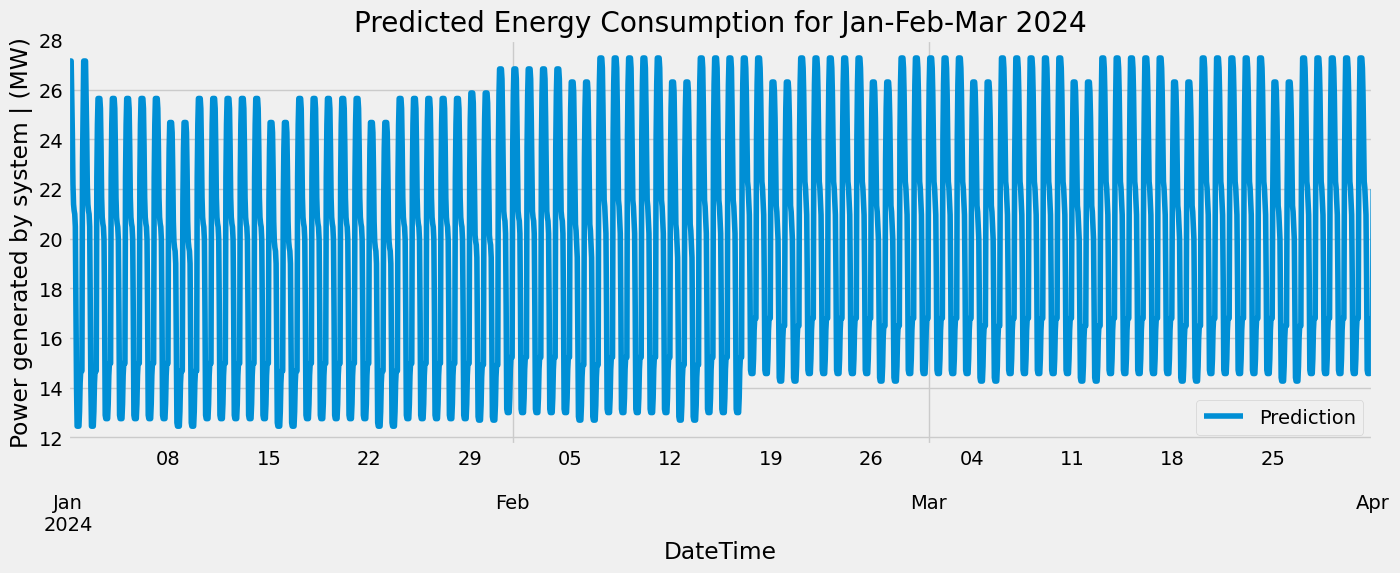

In [201]:
# Create a dataframe with hourly timestamps for Jan, Feb, and Mar 2024
jan_feb_mar_2024 = pd.date_range(start='2024-01-01', end='2024-04-01', freq='H')

# Create features for these timestamps
jan_feb_mar_2024_features = create_features(pd.DataFrame(index=jan_feb_mar_2024))

# Use the trained model to predict energy consumption
predictions = reg.predict(jan_feb_mar_2024_features[FEATURES])

# Create a dataframe to store predictions with timestamps
predicted_df = pd.DataFrame({'DateTime': jan_feb_mar_2024, 'Prediction': predictions})
predicted_df.set_index('DateTime', inplace=True)

# Visualize the predictions
ax = predicted_df.plot(figsize=(15, 5), title='Predicted Energy Consumption for Jan-Feb-Mar 2024')
ax.set_ylabel('Power generated by system | (MW)')
plt.show()

In [202]:
predicted_df.tail(20)

,Prediction
DateTime,
2024-03-31 05:00:00,27.276321
2024-03-31 06:00:00,26.870125
2024-03-31 07:00:00,25.819176
2024-03-31 08:00:00,24.046881
2024-03-31 09:00:00,22.298706
2024-03-31 10:00:00,22.046064
2024-03-31 11:00:00,21.463291
2024-03-31 12:00:00,20.955223
2024-03-31 13:00:00,18.371864


In [169]:
predicted_df = predicted_df.drop(predicted_df.index[-1])

In [170]:
predicted_df.tail(20)

,Prediction
DateTime,
2024-03-31 04:00:00,27.276321
2024-03-31 05:00:00,27.276321
2024-03-31 06:00:00,26.870125
2024-03-31 07:00:00,25.819176
2024-03-31 08:00:00,24.046881
2024-03-31 09:00:00,22.298706
2024-03-31 10:00:00,22.046064
2024-03-31 11:00:00,21.463291
2024-03-31 12:00:00,20.955223


In [171]:
# Define the file path where you want to save the CSV file
predicted_df_file_path = 'predicted_power_generated_Jan_Feb_Mar_2024.csv'

# Save the predicted_df DataFrame to a CSV file
predicted_df.to_csv(predicted_df_file_path)

# Print a message indicating the file has been saved
print(f"Predicted data saved to '{predicted_df_file_path}'")

Predicted data saved to 'predicted_power_generated_Jan_Feb_Mar_2024.csv'


In [172]:
predicted_df

,Prediction
DateTime,
2024-01-01 00:00:00,23.000509
2024-01-01 01:00:00,25.123171
2024-01-01 02:00:00,27.155195
2024-01-01 03:00:00,27.155195
2024-01-01 04:00:00,27.155195
...,...
2024-03-31 19:00:00,15.154738
2024-03-31 20:00:00,16.301758
2024-03-31 21:00:00,16.790878


In [173]:
df_valid = pd.read_csv('wind_power_gen_3months_validation_data.csv')


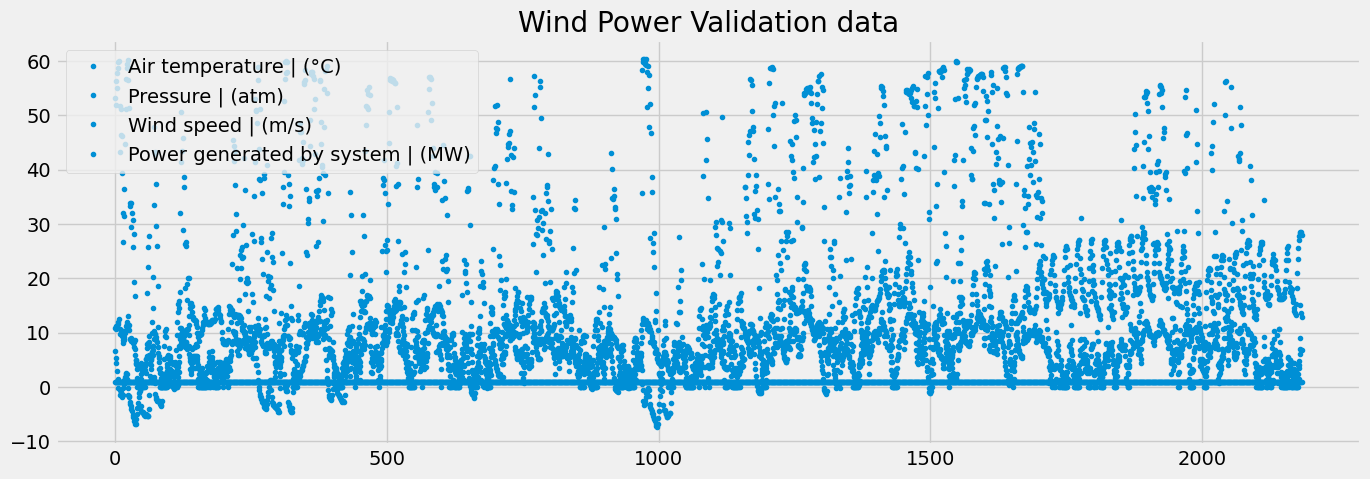

In [174]:
df_valid.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Wind Power Validation data')
plt.show()

RMSE on Validation data: 18.61
MAE on Validation data: 15.86


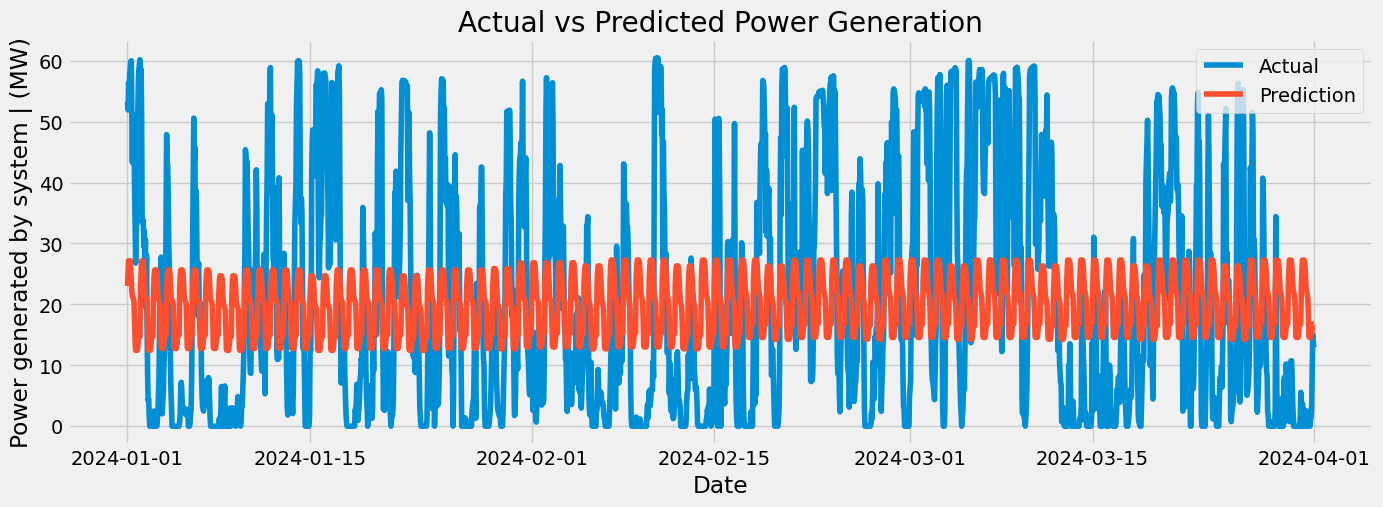

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the validation dataset
df_valid = pd.read_csv('wind_power_gen_3months_validation_data.csv')

# Convert index to datetime
df_valid['DateTime'] = pd.to_datetime(df_valid['DateTime'])
df_valid.set_index('DateTime', inplace=True)

# Merge predicted values with validation data
merged_df = df_valid.merge(predicted_df, how='inner', left_index=True, right_index=True)
merged_df.rename(columns={'Power generated by system | (MW)': 'Actual'}, inplace=True)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(merged_df['Actual'], merged_df['Prediction']))
mae = mean_absolute_error(merged_df['Actual'], merged_df['Prediction'])

print(f'RMSE on Validation data: {rmse:.2f}')
print(f'MAE on Validation data: {mae:.2f}')

# Plot actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(merged_df.index, merged_df['Actual'], label='Actual')
plt.plot(merged_df.index, merged_df['Prediction'], label='Prediction')
plt.title('Actual vs Predicted Power Generation')
plt.xlabel('Date')
plt.ylabel('Power generated by system | (MW)')
plt.legend()
plt.show()


In [176]:
from sklearn.metrics import r2_score, explained_variance_score

# Calculate R-squared
r2 = r2_score(merged_df['Actual'], merged_df['Prediction'])

# Calculate explained variance score
explained_variance = explained_variance_score(merged_df['Actual'], merged_df['Prediction'])

print(f'R-squared on Validation data: {r2:.2f}')
print(f'Explained Variance Score on Validation data: {explained_variance:.2f}')


R-squared on Validation data: 0.08
Explained Variance Score on Validation data: 0.08


# Next Steps
Select different model because Accuracy is Low in XGBoost

# The End